### Importing the modules

In [88]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input,GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc, matthews_corrcoef)
from sklearn.preprocessing import label_binarize
from itertools import cycle

#### Define column names

In [89]:
column_names = ['id', 'entity', 'label', 'text']

#### Loading training and Testing data

In [90]:
df_train = pd.read_csv('twitter_training.csv', encoding='latin-1', header=None, names=column_names)


df_test = pd.read_csv('twitter_validation.csv', encoding='latin-1', header=None, names=column_names)


##### Shapes to confirm the loaded data

In [91]:
print("Training Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)

Training Data Shape: (74682, 4)
Testing Data Shape: (1000, 4)


## Pre processing the data

In [92]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text

In [93]:
df_train['text'] = df_train['text'].apply(preprocess_text)



df_test['text'] = df_test['text'].apply(preprocess_text)

In [94]:
df_train = df_train[df_train['text'] != '']


df_test = df_test[df_test['text']!='']

In [95]:
df_train = df_train[['label','text']]


df_test = df_test[['label','text']]

In [96]:
label_mapping = {'Positive': 3, 'Neutral': 2, 'Irrelevant':1, 'Negative': 0}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [97]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train['text'])
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

In [98]:
y_train = df_train['label'].values
y_test = df_test['label'].values

In [99]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_v = vectorizer.fit_transform(df_train['text'])
X_test_v = vectorizer.transform(df_test['text'])

In [100]:
# Handling class imbalance with resampling
resampler = RandomOverSampler(sampling_strategy='auto')  # You can customize the strategy
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_v, df_train['label'])

In [101]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

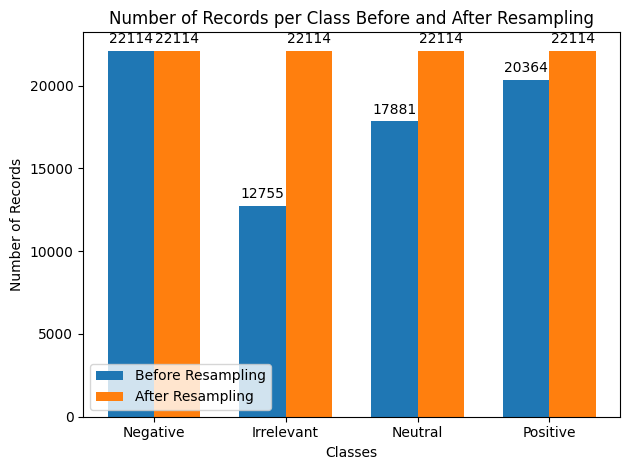

In [102]:
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Count the number of instances per class before resampling
class_counts_before = df_train['label'].value_counts().sort_index()

# Map these counts to their corresponding names
class_counts_before.index = [reverse_label_mapping[i] for i in class_counts_before.index]

# Count the number of instances per class after resampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_counts_after = dict(zip(unique, counts))

# Map these counts to their corresponding names
class_counts_after = {reverse_label_mapping[k]: v for k, v in class_counts_after.items()}

# Prepare plot data
labels_t = sorted(class_counts_before.keys(), key=lambda x: label_mapping[x])  # Sort labels by their mapped values for consistency
before_counts = [class_counts_before[label] for label in labels_t]
after_counts = [class_counts_after.get(label, 0) for label in labels_t]

x = np.arange(len(labels_t))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_counts, width, label='Before Resampling')
rects2 = ax.bar(x + width/2, after_counts, width, label='After Resampling')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Records')
ax.set_title('Number of Records per Class Before and After Resampling')
ax.set_xticks(x)
ax.set_xticklabels(labels_t)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

##### MODEL Intialization

In [103]:
nb_classifier = MultinomialNB()

In [104]:
svm_classifier = SVC(kernel='linear', class_weight='balanced')

In [106]:
labels = df_train['label'].unique()


model = Sequential([
    Input(shape=(100,)),
    Embedding(15599, 100, input_length=100),
    Dropout(0.5),
    Bidirectional(LSTM(150, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(len(labels), activation='softmax')
])

/home/ujwal/anaconda3/envs/cis568/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [107]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [108]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │     1,559,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 300)       │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 300)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,864 (7.14 MB)

 Trainable params: 1,870,864 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

In [109]:
nb_classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [110]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), class_weight=class_weights_dict)

Epoch 1/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.4985 - loss: 1.1069 - val_accuracy: 0.8869 - val_loss: 0.3576
Epoch 2/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.8320 - loss: 0.4537 - val_accuracy: 0.9419 - val_loss: 0.1949
Epoch 3/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.8844 - loss: 0.3103 - val_accuracy: 0.9479 - val_loss: 0.1642
Epoch 4/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.9063 - loss: 0.2496 - val_accuracy: 0.9499 - val_loss: 0.1539
Epoch 5/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - accuracy: 0.9211 - loss: 0.2070 - val_accuracy: 0.9570 - val_loss: 0.1580
Epoch 6/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.9301 - loss: 0.1851 - val_accuracy: 0.9459 - val_loss: 0.1689
Epoch 7/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.9366 - loss: 0.1635 - val_accuracy: 0.9459 - val_loss: 0.1844
Epoch 8/40
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - accuracy: 0.9401 -

In [111]:
svm_classifier.fit(X_train_resampled, y_train_resampled)

SVC(class_weight='balanced', kernel='linear')

#### Prediction of the model

In [112]:
nb_predictions = nb_classifier.predict(X_test_v)

In [113]:
svm_predictions = svm_classifier.predict(X_test_v)

In [114]:
cnn_predictions = model.predict(X_test)
cnn_prediction_class = np.argmax(cnn_predictions, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


#### Accuracies 

In [115]:
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Accuracy: {:.2f}%".format(nb_accuracy * 100))

Accuracy: 73.27%


In [116]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy: {:.2f}%".format(svm_accuracy * 100))

Accuracy: 83.78%


In [117]:
cnn_accuracy = accuracy_score(y_test, cnn_prediction_class)
print("Accuracy: {:.2f}%".format(cnn_accuracy * 100))

Accuracy: 95.30%


#### Visualizing the Results

In [118]:
y_true = y_test

In [119]:
predictions_nb = nb_predictions
predictions_svm = svm_predictions 
predictions_cnn = cnn_prediction_class

In [120]:
models = {
    'Naive Bayes': predictions_nb,
    'SVM': predictions_svm,
    'CNN': predictions_cnn
}

In [121]:
results = {}
for name, predictions in models.items():
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='macro')
    recall = recall_score(y_true, predictions, average='macro')
    f1 = f1_score(y_true, predictions, average='macro')
    mcc = matthews_corrcoef(y_true, predictions)  # Matthews Correlation Coefficient

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc
    }

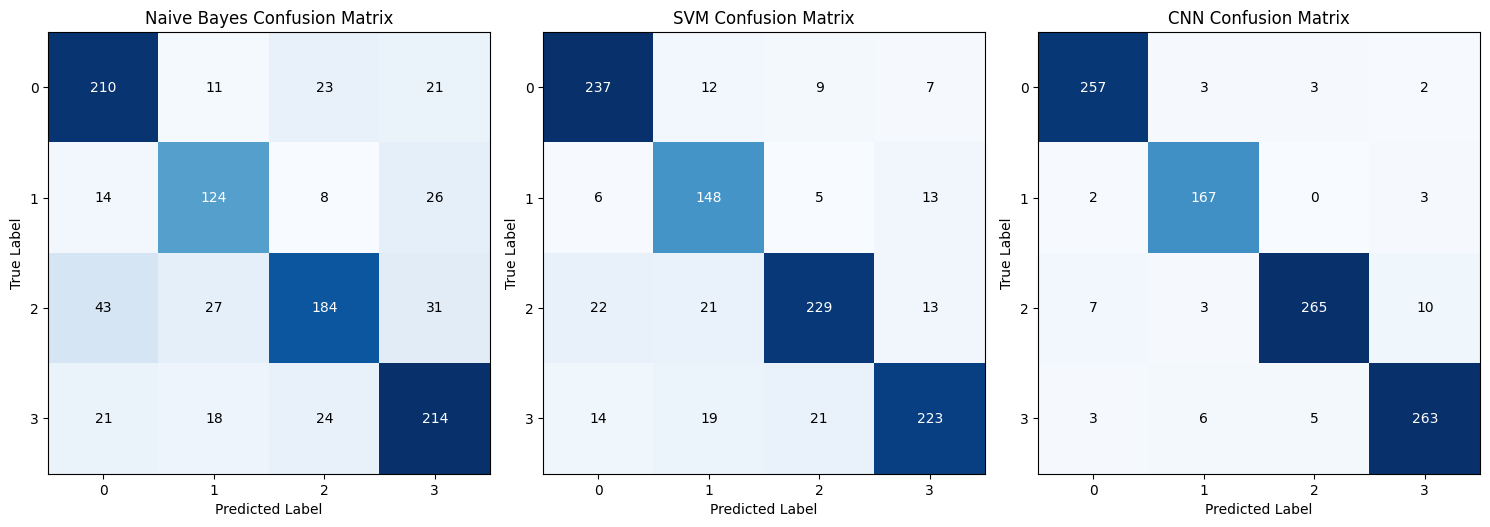

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, (name, predictions) in zip(axes, models.items()):
    cm = confusion_matrix(y_true, predictions)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xticks(np.arange(len(set(y_true))))
    ax.set_yticks(np.arange(len(set(y_true))))
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

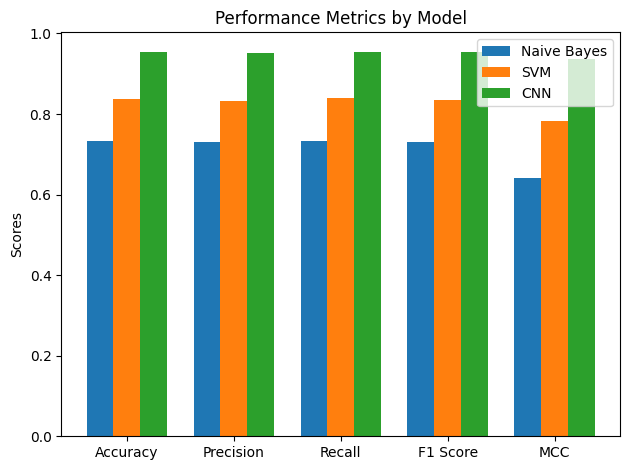

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC']
x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots()
for i, (name, vals) in enumerate(results.items()):
    data = [vals[metric] for metric in metrics]
    ax.bar(x + i * width, data, width, label=name)

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()